# Overview
Use this notebook to convert an OCT image you have to a virtual H&E image for evaluation.

To get started,
[open this notebook in colab](https://colab.research.google.com/github/WinetraubLab/zero_shot_segmentation/blob/main/testing_sam.ipynb)
 and run.


# inputs

Assumptions:

oct scan x/z rates:
*   microns per pixel z = 1
*   microns per pixel x = 1

pix2pix input sizes:
*   virtual histology input width = 256
*   virtual histology input height = 256

pix2pix input x/z rates:
*   microns per pixel z = 1
*   microns per pixel x = 2

In [2]:
# Pre-processed dataset
preprocessed_dataset_path = "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x OCT2Hist Model (Paper V2)/Results/TestSet/"

# Define input images
preprocessed_oct_image_paths = [
 (preprocessed_dataset_path + "LE-03-Slide04_Section01_yp0_patch01_real_A.png"), # Used in Paper Figure 3.b
 (preprocessed_dataset_path + "LG-19-Slide04_Section02_yp0_patch01_real_A.png"), # Used in Paper Figure 3.c
 (preprocessed_dataset_path + "LF-01-Slide04_Section02_yp0_patch01_real_A.png"), # Used in Paper Figure 3.d
 (preprocessed_dataset_path + "LG-44-Slide05_Section03_yp0_patch01_real_A.png"), # Used in Paper Figure 3.e
]
preprocessed_oct_image_paths = [s.replace("_real_A", "_fake_B") for s in preprocessed_oct_image_paths]
print(preprocessed_oct_image_paths)

['/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x OCT2Hist Model (Paper V2)/Results/TestSet/LE-03-Slide04_Section01_yp0_patch01_fake_B.png', '/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x OCT2Hist Model (Paper V2)/Results/TestSet/LG-19-Slide04_Section02_yp0_patch01_fake_B.png', '/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x OCT2Hist Model (Paper V2)/Results/TestSet/LF-01-Slide04_Section02_yp0_patch01_fake_B.png', '/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x OCT2Hist Model (Paper V2)/Results/TestSet/LG-44-Slide05_Section03_yp0_patch01_fake_B.png']


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
#segment anything (sam)
using_colab = True
visualize_sam_outputs = True

#sam algorithm input parameters
points_per_side=32
pred_iou_thresh=0.90
stability_score_thresh=0.95
crop_n_layers=1
crop_n_points_downscale_factor=2
min_mask_region_area=3000

#sam model type and weights checkpoint
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

In [5]:
FIG_SIZE = (5,5)

In [6]:
#rf - roboflow dataset related params
rf_api_key="R04BinsZcBZ6PsfKR2fP"
rf_workspace="yolab-kmmfx"
rf_project = "connect_from_colab"
rf_dataset = "png-mask-semantic"

In [ ]:
%pip install dataclasses-json
%pip install supervision
from IPython.display import clear_output
clear_output()

In [ ]:
!git clone --recurse-submodules https://github.com/WinetraubLab/zero_shot_segmentation.git


In [ ]:
!git clone --recurse-submodules https://github.com/WinetraubLab/OCT2Hist-ModelInference


In [ ]:
!pip install torch
!pip install torchvision
import torch
import torchvision

In [ ]:
%run /content/zero_shot_segmentation/setup_roboflow_and_sam.ipynb
from IPython.display import clear_output
clear_output()

In [ ]:
sys.path.append('/content/zero_shot_segmentation')

from zero_shot_utils.utils import visualize_masks_on_img

#Zero shot pipeline

In [144]:
# Path to an OCT image to convert
oct_input_image_path = preprocessed_oct_image_paths[0]

#run sam on virtual histology

To generate masks, just run `generate` on an image.

In [145]:
import cv2

input = cv2.imread(oct_input_image_path)

In [146]:
masks = mask_generator.generate(input)

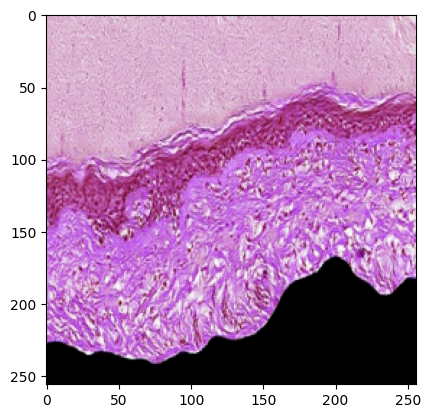

In [149]:
sys.path.append('/content/OCT2Hist-ModelInference')
from utils.show_images import showImg
showImg(input)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

Show all the masks overlayed on the image.

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:[link text](https://)


#project on oct

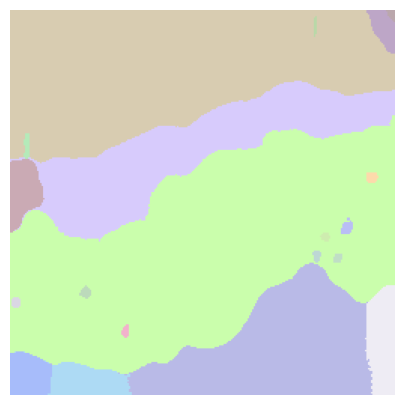

In [150]:
import numpy as np
white_image = np.ones_like(input) * 255
visualize_masks_on_img(white_image, masks, FIG_SIZE)

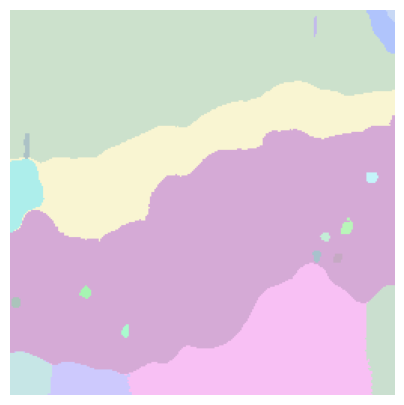

In [151]:
mask_generator.stability_score_thresh=0.02
masks2 = mask_generator.generate(input)
visualize_masks_on_img(white_image, masks2, FIG_SIZE)

In [37]:
masks2[0].keys()

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])

In [42]:
input.shape

(256, 256, 3)

In [152]:
sorted_masks = sorted(masks2, key=(lambda x: x['area']), reverse=True)
sorted_masks[0]['bbox'] # XYWH format



[0, 0, 255, 255]

In [153]:
def show_anns_for_single_mask(ann):
  ax = plt.gca()
  ax.set_autoscale_on(False)
  img = np.ones((ann['segmentation'].shape[0], ann['segmentation'].shape[1], 4))
  img[:,:,3] = 0
  m = ann['segmentation']
  color_mask = np.concatenate([np.random.random(3), [0.35]])
  img[m] = color_mask
  ax.imshow(img)

x,y,w,h:(0, 0, 255, 255)
predicted_iou:1.0084675550460815
stability_score:0.8419346213340759
point_coords:[[4.0, 196.0]]


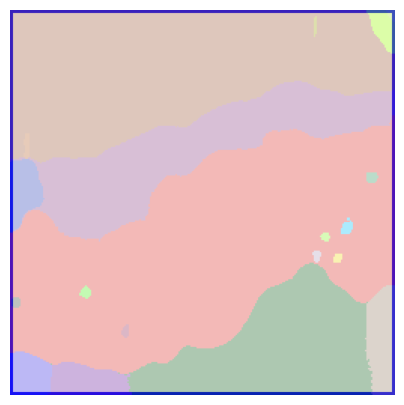

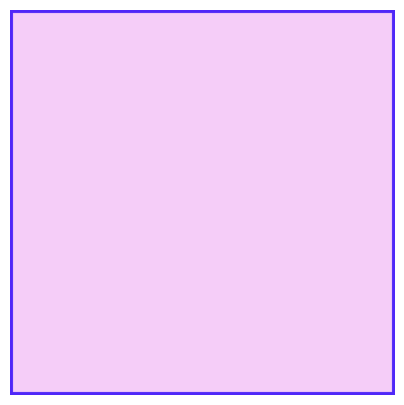

x,y,w,h:(0, 0, 255, 153)
predicted_iou:0.9534316658973694
stability_score:0.9345602989196777
point_coords:[[156.0, 68.0]]


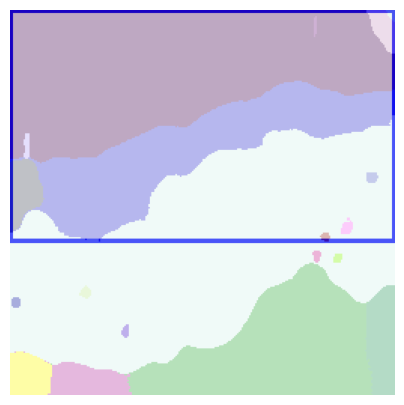

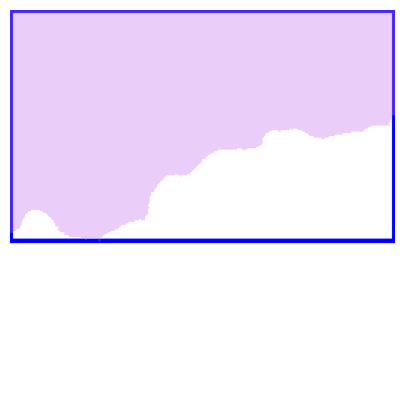

x,y,w,h:(0, 0, 255, 101)
predicted_iou:1.025307536125183
stability_score:0.9885677695274353
point_coords:[[204.0, 4.0]]


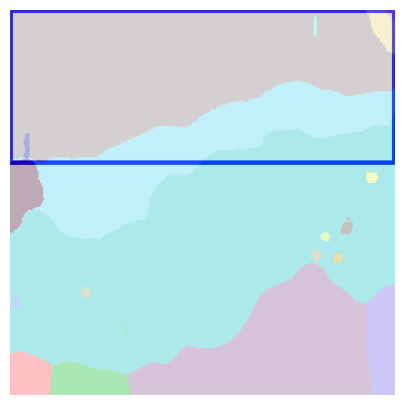

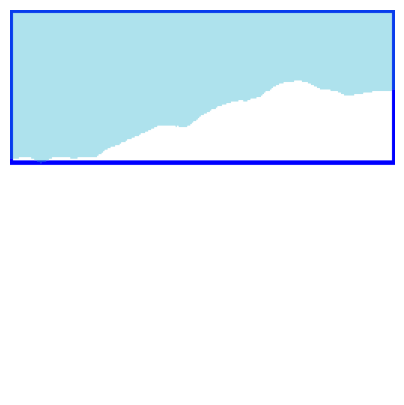

x,y,w,h:(0, 168, 255, 87)
predicted_iou:1.0071974992752075
stability_score:0.9887265563011169
point_coords:[[196.0, 244.0]]


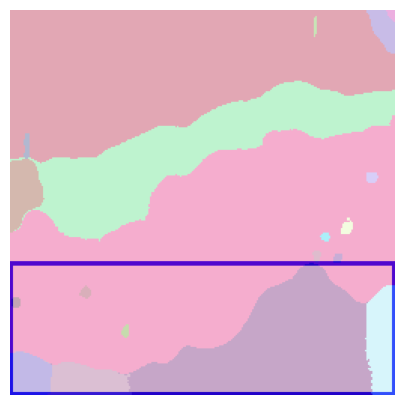

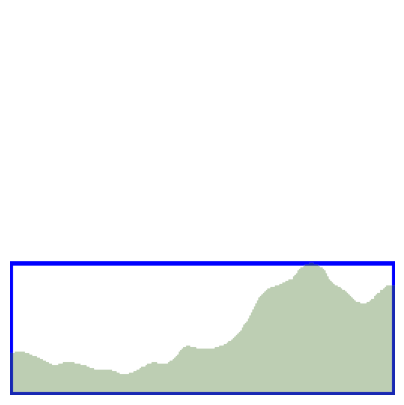

x,y,w,h:(0, 227, 80, 28)
predicted_iou:0.9671850204467773
stability_score:0.4394771158695221
point_coords:[[52.0, 244.0]]


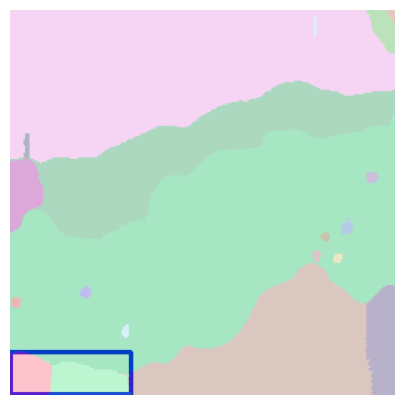

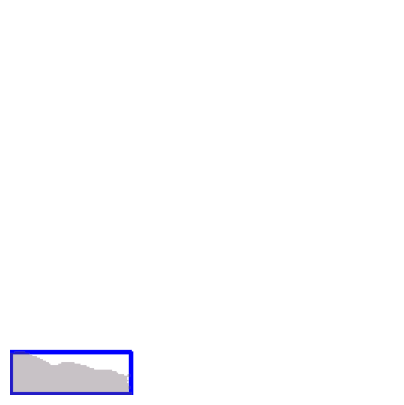

x,y,w,h:(236, 183, 19, 72)
predicted_iou:0.9012653231620789
stability_score:0.8868640661239624
point_coords:[[244.0, 228.0]]


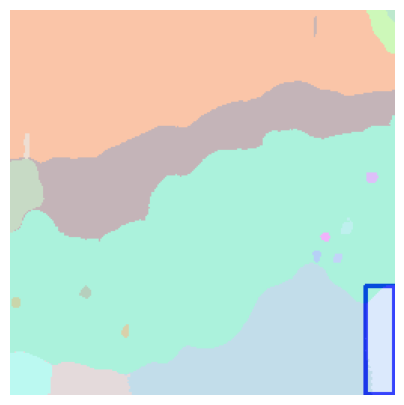

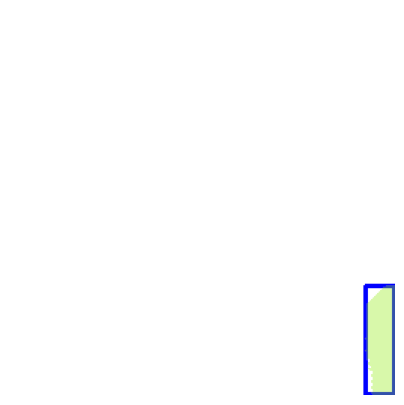

x,y,w,h:(0, 99, 22, 48)
predicted_iou:0.9419638514518738
stability_score:0.9655612111091614
point_coords:[[12.0, 132.0]]


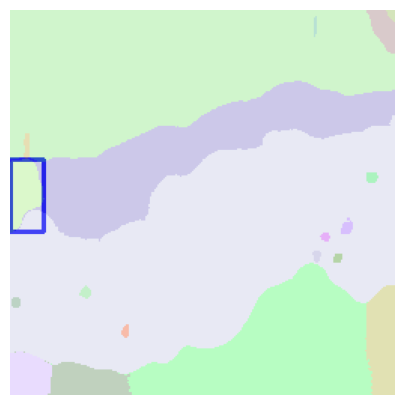

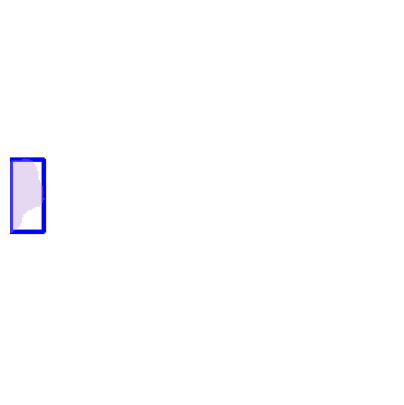

x,y,w,h:(0, 227, 27, 28)
predicted_iou:0.9619874358177185
stability_score:0.9696551561355591
point_coords:[[20.0, 244.0]]


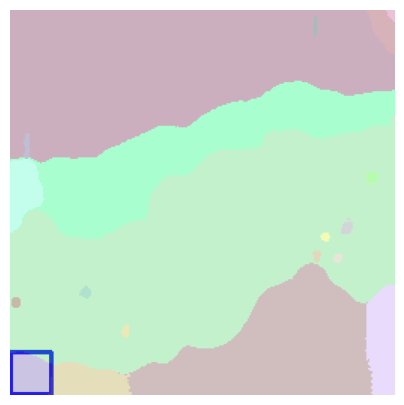

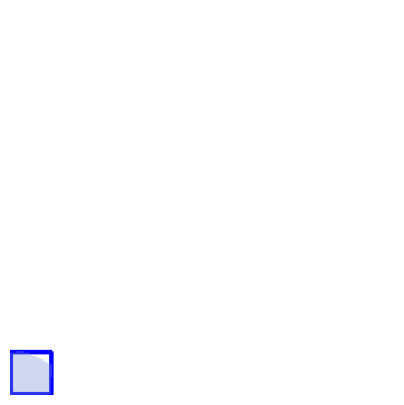

x,y,w,h:(237, 0, 18, 28)
predicted_iou:0.923637866973877
stability_score:0.8708010315895081
point_coords:[[244.0, 4.0]]


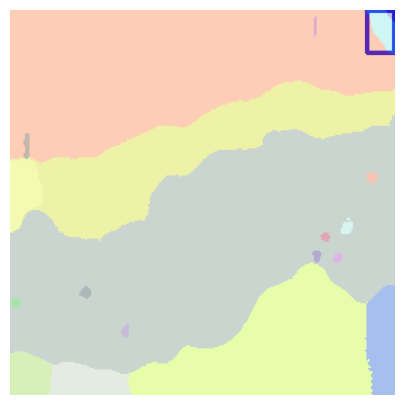

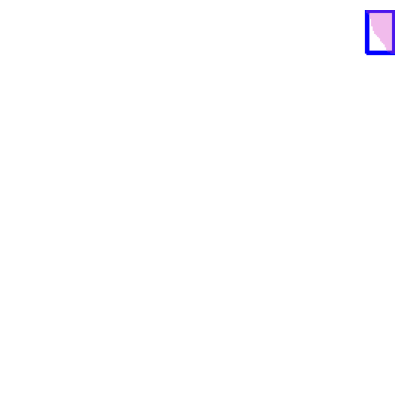

x,y,w,h:(220, 138, 7, 10)
predicted_iou:0.8840996026992798
stability_score:0.9516128897666931
point_coords:[[220.0, 148.0]]


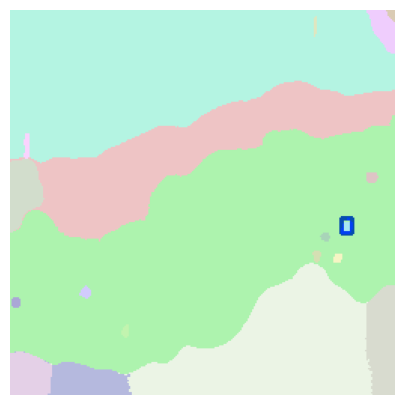

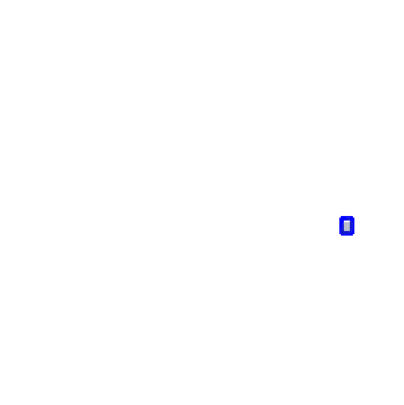

In [156]:
for i_mask in range(10):
  x,y,w,h = sorted_masks[i_mask]['bbox']
  print(f"x,y,w,h:{x,y,w,h}")
  predicted_iou = sorted_masks[i_mask]['predicted_iou']
  print(f"predicted_iou:{predicted_iou}")
  stability_score = sorted_masks[i_mask]['stability_score']
  print(f"stability_score:{stability_score}")
  point_coords = sorted_masks[i_mask]['point_coords']
  print(f"point_coords:{point_coords}")
  import matplotlib.pyplot as plt
  color = (0, 0, 255)  # Red color in BGR format
  thickness = 2  # You can adjust the thickness
  image_with_rectangle = cv2.rectangle(white_image.copy(), (x, y), (x + w, y + h), color, thickness)
  visualize_masks_on_img(image_with_rectangle, masks2, FIG_SIZE)


  plt.figure(figsize=FIG_SIZE)
  plt.imshow(image_with_rectangle)
  show_anns_for_single_mask(sorted_masks[i_mask])
  plt.axis('off')
  plt.show()

# from zero_shot_utils.utils import show_anns
# show_anns(masks2)
# plt.axis('off')
# plt.imshow(image_with_rectangle)


0 227 79 28


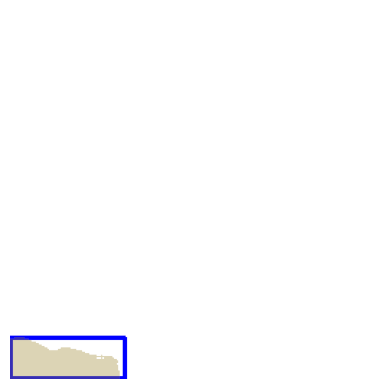

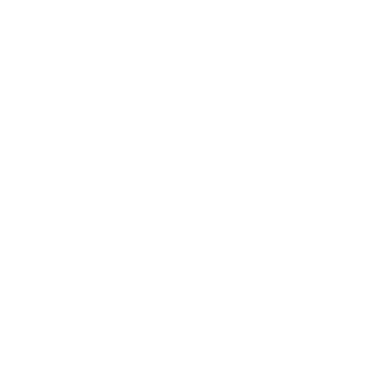

In [118]:
#1. remove overlapping segmentations, such that each mask does not contain another mask.
#2. look for two masks, with a mutual border, and the sum of both widths is the width of the image.
#3. filter those on top or bottom of the image.
#4. if more than 1 candidate remains, return an error

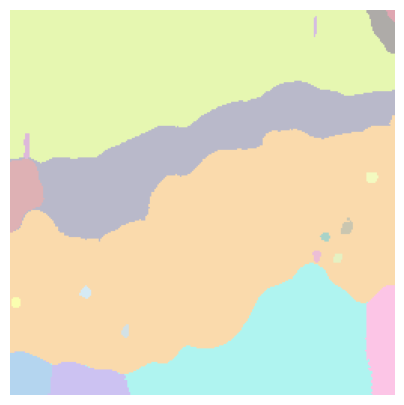

In [35]:
mask_generator.stability_score_thresh=0.75
masks2 = mask_generator.generate(input)
visualize_masks_on_img(white_image, masks2, FIG_SIZE)

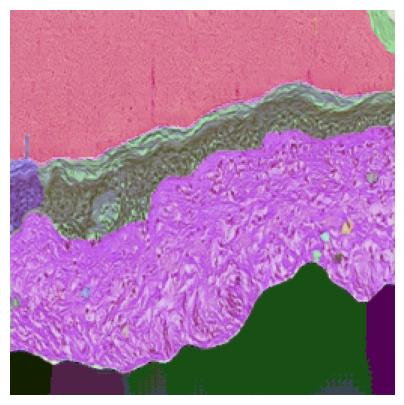

In [28]:
visualize_masks_on_img(input, masks2, FIG_SIZE)